# **Data Visualization Notebook**

## Objectives

* Answer business requirement 1: A study to visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/validation

## Outputs

* Image shape in a pickle file
* Mean and (variability) standard deviation of images for healthy leaves and ones with powdery mildew.
* Plot to present contrast between healthy and powdery mildew leaf images.
* Generate code that answers business requirement 1 and can e used as input when building dashboards.

---

## Set working directory

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
current_dir = os.getcwd()
current_dir

'/workspaces/detect-mild-dew-in-cherry-leaves'

Set `test`, `train` and `validation` paths as variables

In [ ]:
data_dir = 'inputs/mildew_dataset/cherry-leaves'
test_path = f'{data_dir}/test'
train_path = f'{data_dir}/train'
valid_path = f'{data_dir}/validation'


## Set output directory

In [3]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


Set label names

In [4]:
labels = os.listdir(train_path)
print("Lables are:", labels)

Lables are: ['powdery_mildew', 'healthy']


---

# Data visualisation - image data

---

*Import libraries*

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### **Image shape**

Compute average images size on train set.

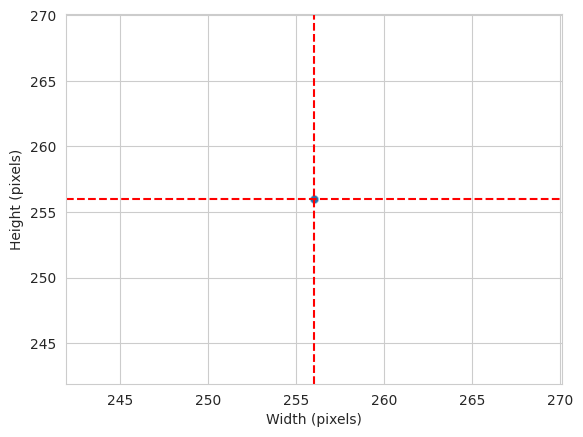

Width average: 256 
Height average: 256


In [6]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


Images size for training the model is the average from all images in the train set.

In [7]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save image shape embeddings as pickle

In [8]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

### Average and variability of images per label

#### Load image shapes and labels in an array

In [9]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


2025-11-08 04:03:43.726326: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-08 04:03:58.935901: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Run `load_image_as_array()`

In [10]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)


(60, 256, 256, 3) (60,)


### Plot and save mean and variability of images per label

In [11]:
def plot_mean_variability_per_labels(X, y, figsize=(8, 4), save_image=False):
    """
    Plots the mean and variability (standard deviation) of images per label.

    Args:
        X (np.ndarray): Array of images, shape (n_samples, height, width[, channels]).
        y (array-like): Corresponding labels for each image.
        fig_size (tuple): Figure size for the plot.
        save_image (bool): If True, saves the plot images.
        output_dir (str): Directory to save plots if save_image=True.
    """

    labels = np.unique(y)

    for label in labels:
        # Select subset of images for the label
        subset = X[np.array(y) == label]

        # Compute mean and std deviation across the stack
        mean_image = np.mean(subset, axis=0)
        std_image = np.std(subset, axis=0)

        # Plot mean and variability
        print(f"==== Label {label} ====")
        print(f"Image Shape: {mean_image.shape}")        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(f"Label: {label}", fontsize=14)

        axes[0].imshow(mean_image, cmap='gray')
        axes[0].set_title("Average Image")
        axes[0].axis("off")

        axes[1].imshow(std_image, cmap='gray')
        axes[1].set_title("Variability (Std Dev)")
        axes[1].axis("off")

        plt.tight_layout()

        if save_image:
            save_path = os.path.join(file_path, f"average_variability_{label}.png",
                                    bbox_inches='tight', dpi=300)
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()



==== Label healthy ====
Image Shape: (256, 256, 3)


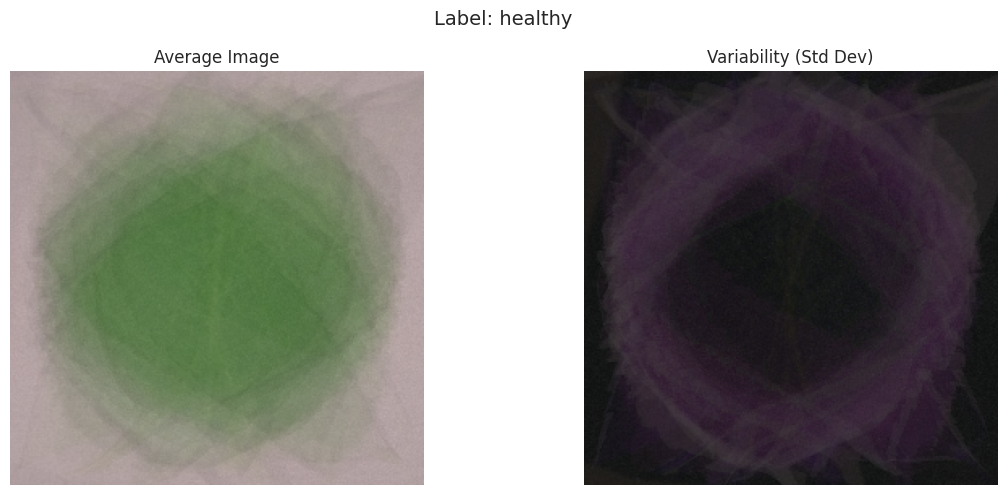

==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


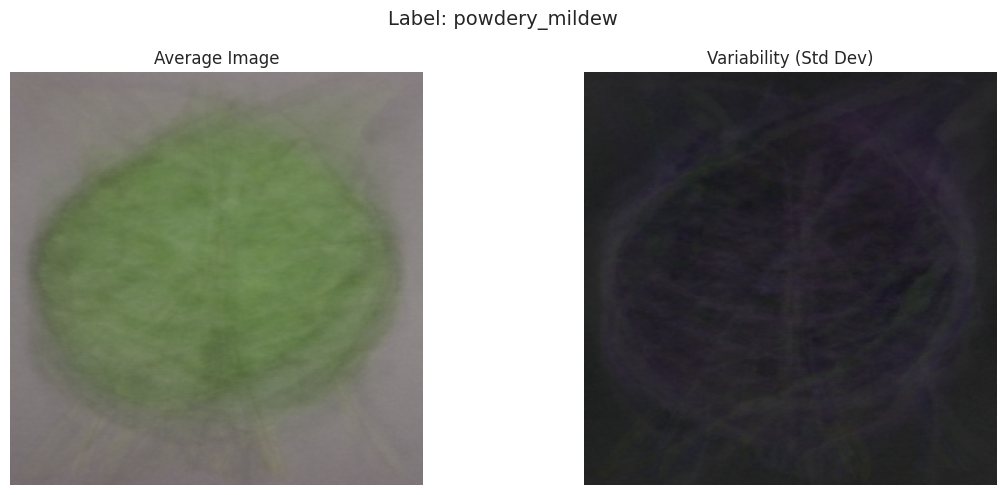

In [12]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=False)

---

## Difference between average mildew-contained and healthy leaf images

define functions - taken from Code Institute 

In [13]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label_1} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference: Avg {label_1} - {label_2}')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    if save_image:
        plt.savefig(f"{file_path}/average_difference.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


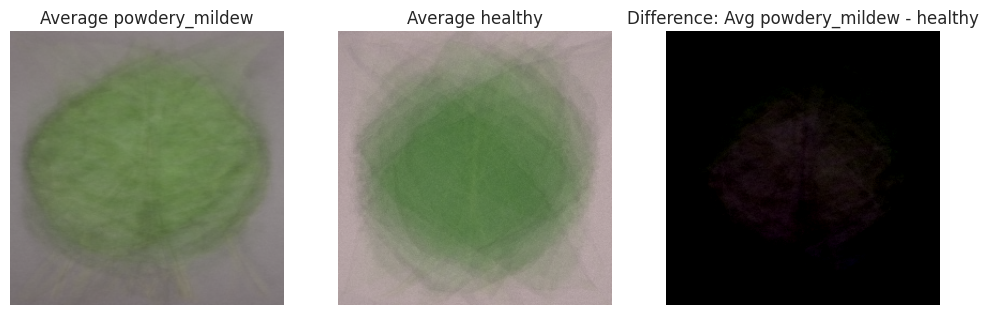

In [14]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

## Image Montage

In [53]:
import random
from PIL import Image
# import numpy as np


def create_image_montage(dir_path, display_label, nrows=2, ncols=2, figsize=(15, 9)):
    
    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if display_label in labels:
        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + display_label)
        no_images_2display = nrows * ncols
        if no_images_2display < len(images_list):
            img_idx = random.sample(images_list, no_images_2display)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {no_images_2display} spaces")
            return

        # Randomly select images
        selected_images = random.sample(images_list, no_images_2display)


        # display image montage
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()

        for i, file_name in enumerate(selected_images):
            img_path = f"{dir_path}/{display_label}/{file_name}"
            # img = imread(img_path)
            # img_shape = img.shape
            # axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            # axes[plot_idx[x][0], plot_idx[x][1]].set_title(
            #     f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            # axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            # axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
            img = Image.open(img_path)
            axes[i].imshow(np.array(img))
            axes[i].axis('off')

        # Turn off any unused axes
        for i in range(no_images_2display, len(axes)):
            axes[i].axis('off')

        plt.suptitle(f"Montage of label: {display_label}", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")



Label: powdery_mildew


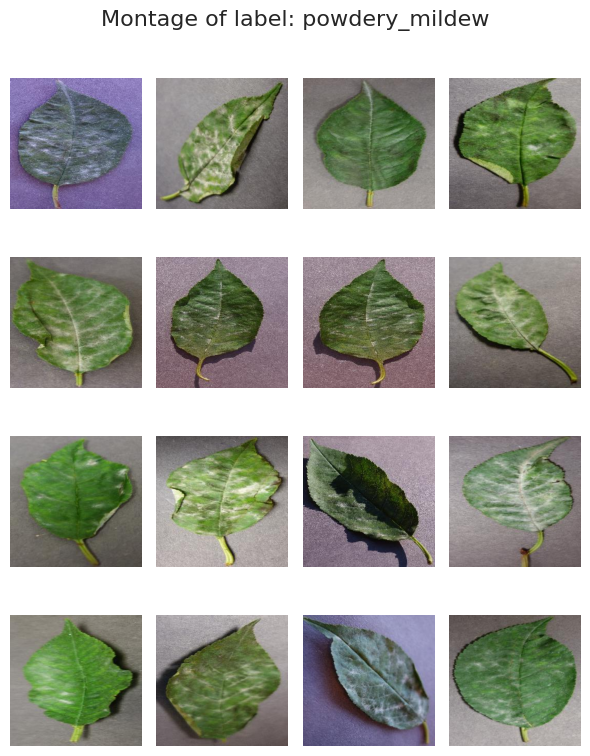



Label: healthy


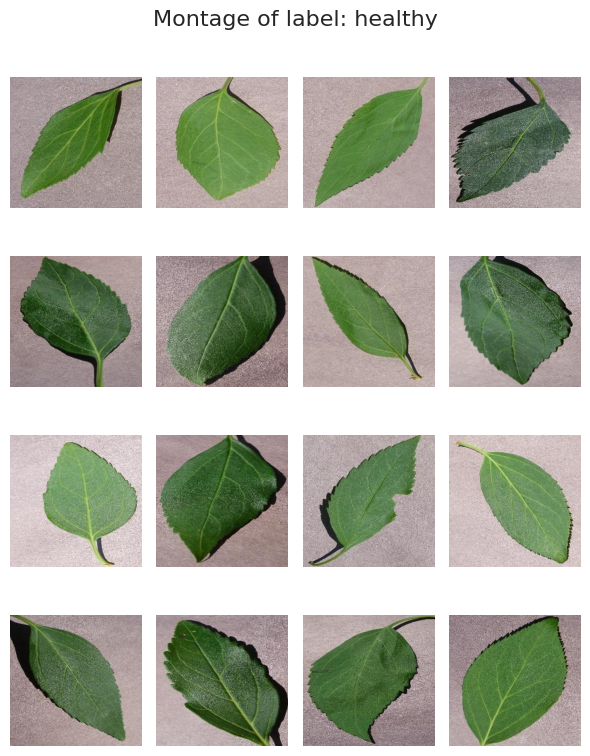

In [ ]:
# Test for both labels:
for label in labels:
    print(f"Label: {label}")
    create_image_montage(dir_path=train_path,
                  display_label=label,
                  nrows=4, ncols=4,
                  figsize=(10, 15)
                  )
    print("\n")

---

# Conclusions and Next Steps

* Business requirement 1 has been answered
* An average and variability images created 
* Average difference image generated 
* Code for image montage created and will be used when building dashboards.